# Projet 5 : Segmentez des clients d'un site e-commerce

## Notebook 3 : Contrat de maintenance – Simulations 

L’objectif est de déterminer au bout de combien de temps le modèle de clustering entraîné (« fit ») initialement proposé devient obsolète, c'est à dire quand les prédictions (« predict ») ne sont plus pertinentes, nécessitant d’entraîner un nouveau modèle de clustering.

In [1]:
# importation des bibliothèques nécessaires
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score

In [2]:
#on va regarder la periode totale des commandes du dataset orders
orders_dataset = pd.read_csv('brazilian_ecommerce_dataset/olist_orders_dataset.csv')
orders_dataset =orders_dataset[orders_dataset['order_status'] == 'delivered']
orders_dataset['order_purchase_timestamp'] = orders_dataset['order_purchase_timestamp'].astype('datetime64[ns]')

orders_dataset.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [3]:
# On regarde la periode sur laquelle on va se concentrer 
time_delta = int((orders_dataset['order_purchase_timestamp'].max() - orders_dataset['order_purchase_timestamp'].min())/np.timedelta64(1,'M'))
print("La période complète des commandes porte sur {} mois.".format(time_delta))

La période complète des commandes porte sur 23 mois.


In [4]:
# fonction qui va créer le dataframe final en selectionnant les periodes voulues
# period_weeks corresponds au nombre de semaines à rajouter dans le dataframe crée sur un an 
def make_dataset(initial,period):
    #on importe le dataframe
    df_total = pd.read_csv('df_total.csv', index_col = 0)
    
    # on met sous forme de data la colonne de la date de commande
    df_total['order_purchase_timestamp'] = df_total['order_purchase_timestamp'].astype('datetime64[ns]')
    # on selectionne la periode qu'on veut dans le dataframe 
    # la date de début : la premiere date du dataframe
    start = df_total.order_purchase_timestamp.min()
    # la date de fin : 
    # si on est dans le cas initial donc garde une periode d'un an a partir de la date de début
    if(initial == True):
        stop = start + pd.DateOffset(months=12)
    # si on est dans le cas dans simulations on prends une periode d'un an plus des semaines (nombre de semaines: period)
    else:
        stop_initial = start + pd.DateOffset(months=12)
        stop = stop_initial + timedelta(weeks=period)
    #on selectionne la periode voulue dans le dataframe 
    df_total = df_total[df_total["order_purchase_timestamp"] < stop]
    
    #On fait une aggregation pour avoir un dataframe avec une ligne par commande
    dict_agg = {'customer_unique_id':'first',
            'order_purchase_timestamp':'first', #un date par commande
            'order_delivered_customer_date':'first', #une date par commande
            'order_item_id':'max', #avoir le nombre de produits dans la commande
           'payment_value':'first', # le payment_value est le prix de la commande
           'review_score':'first', # un score par commande
           'product_category_name':'unique'}

    df_per_order = df_total.groupby(["order_id"]).agg(dict_agg)
    df_per_order = df_per_order.reset_index()
    
    
    #On fait une aggregation pour avoir un dataframe par client unique
    dict_agg_customer = {'order_id':'count', #pour savoir le nombre de commandes par client
                     'order_purchase_timestamp':'max', #date d'achat de la dernière commande
                     'order_delivered_customer_date':'max', #date de livraison de la dernière commande
                     'order_item_id':'sum', #avoir le nombre de produits acheté par le client
                     'payment_value':'sum', # montant total depensé par le client
                     'review_score':'mean', # le score moyen que le client a donné
                        } 

    df_per_customer = df_per_order.groupby(["customer_unique_id"]).agg(dict_agg_customer)
    df_per_customer = df_per_customer.reset_index()
    df_per_customer = df_per_customer.rename(columns = {'order_id':'nbr_commandes',
                                                   'order_purchase_timestamp':'date_achat_derniere_commande',
                                                   'order_delivered_customer_date':'date_livraison_derniere_commande', #date de livraison de la dernière commande
                                                    'order_item_id':'nbr_pdt_achetés', #avoir le nombre de produits acheté par le client
                                                    'payment_value':'montant_depensé', # montant total depensé par le client
                                                        'review_score':'score_moyen'})
    # Creation des variables : Recency, Frequency, Monetary
    # On prends la date de derniére commande comme notre date de comparaison
    ref_date = df_total['order_purchase_timestamp'].max()
    # On renomme les colonnes pour avoir les variables Frequency et Monetary
    df_per_customer.rename(columns={'nbr_commandes':"Frequency",
                           'montant_depensé' :'Monetary'}, inplace=True)
    #On calcule la variable recency
    df_per_customer['Recency'] = df_per_customer['date_achat_derniere_commande'].apply(lambda x: (ref_date - x).days)
    # On calcule le delai de livraison
    df_per_customer['date_livraison_derniere_commande'] = df_per_customer['date_livraison_derniere_commande'].astype('datetime64[ns]')
    df_per_customer['delai livraison'] = df_per_customer['date_livraison_derniere_commande'] - df_per_customer['date_achat_derniere_commande']
    df_per_customer['delai livraison'] = df_per_customer['delai livraison'].apply(lambda x: x.days)
    
    df_per_customer = df_per_customer[['Recency', 'Frequency', 'Monetary','delai livraison','score_moyen']]
    return df_per_customer

In [5]:
# on calcule le dataframe initial sur une periode de 12 mois
df0 = make_dataset(initial = True, period = 0)
df0.shape

(25945, 5)

In [6]:
#On normalise le dataframe initial
scaler = MinMaxScaler()
sc0 = scaler.fit_transform(df0)

df0_sc0 = pd.DataFrame(sc0)
df0_sc0.columns = df0.columns

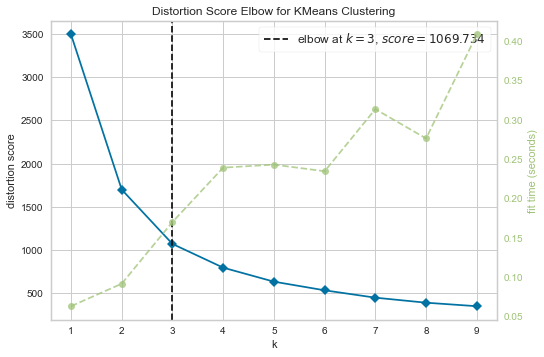

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [7]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))

visualizer.fit(sc0)    # Fit the data to the visualizer
visualizer.poof()            # Draw/show/poof the data

In [8]:
#on applique Kmeans
kmeans = KMeans(n_clusters= visualizer.elbow_value_)
kmeans.fit(sc0)

KMeans(n_clusters=3)

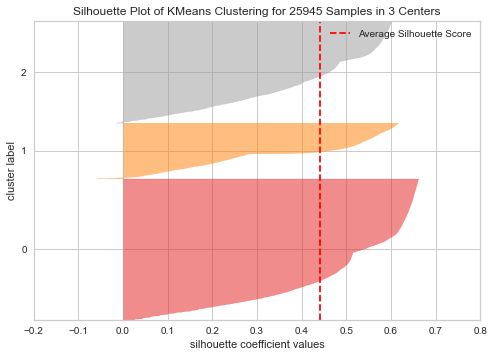

In [9]:
#Silhouette Visualizer 
visualizer = SilhouetteVisualizer(kmeans)
visualizer.fit(sc0)                      # Fit the data to the visualizer
visualizer.poof();                            # Draw/show/poof the data

In [10]:
df0['cluster'] = kmeans.labels_
df0['cluster'].value_counts()

0    12271
2     8833
1     4841
Name: cluster, dtype: int64

#### on va donc choisir comme nombre de clusters pour le KMeans = 3

### Calcul du ARI score

In [11]:
def ARI_iterator():
    ari_score = []
    #on crée le dataframe initial
    df0 = make_dataset(initial = True, period = 0)
    #On normalise le dataframe initial avec un min max scaler
    scaler_0 = MinMaxScaler()
    sc0 = scaler.fit(df0)
    df0_sc0 = sc0.transform(df0)

    #on applique Kmeans
    kmeans0 = KMeans(n_clusters=3)
    kmeans0.fit(df0_sc0)

    #on va creer un dataframe en partant de start et jusqu'à stop= stop de df0 + p semaines
    #on choisit de calculer l'ARI Score toutes les 2 semaines
    #donc p va être egale à 2 puis 4, 6, 8, 10.. 42
    
    for p in np.arange(2,((time_delta-12)*4),2).tolist():
        # On crée le dataframe sur la periode qu'on veut 
        dfp = make_dataset(initial = False, period = p)
        
        # On normalise les données 
        scaler_p = MinMaxScaler()
        scp = scaler_p.fit(dfp)
        
        # dataframe normalisé avec scp (nouveau scaler)
        dfp_scp = scp.transform(dfp)
        
        # dataframe normalisé avec sc0 (ancien scaler)
        dfp_sc0 = sc0.transform(dfp)
        
        # On applique le K-Means à dfp_scp
        kmeans_p = KMeans(3, random_state=42)
        kmeans_p.fit(dfp_scp)

        # On calcule ARI score
        # kmeans0.predict(dfp_sc0) : labels donnés par l'ancien modèle sur les nouvelles données 
        # kmeans_p.predict(dfp_scp) : labels données par le nouveau modèle sur les nouvelles données
        
        ari_p = adjusted_rand_score(kmeans0.predict(dfp_sc0), kmeans_p.predict(dfp_scp))
        # on ajoute le score calculé à la liste de scores
        ari_score.append(ari_p)
        
    return ari_score

In [12]:
# on calcule l'ARI score avec la fonction crée 
ari_p = ARI_iterator()
ari_p

[0.9511682424762645,
 0.9009719434925548,
 0.7965209470645578,
 0.7776829532529743,
 0.7634883466718697,
 0.7254026705111574,
 0.693409286499875,
 0.6757712893655704,
 0.6606635552120158,
 0.6318359103143687,
 0.6270997395538611,
 0.6043319195728082,
 0.5326363414885156,
 0.5034270571262757,
 0.4982656521064983,
 0.47856103062540023,
 0.44858616180746164,
 0.424155679174104,
 0.4059823663010803,
 0.3873116188417277,
 0.37137795186175226]

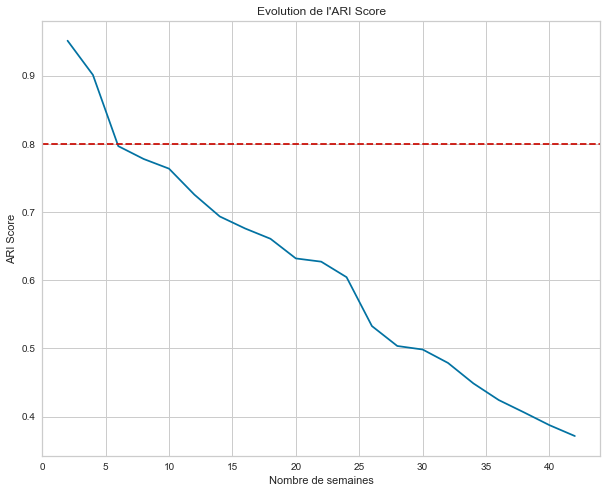

In [13]:
# on trace l'ARI score en fonction du nombre de semaines à partir duquel il faut entrainer un nouveau modele de clustering
# On choisit une limite d'ARI score de 0.8, si l’ARI passe en dessous de 0.8, il est sûrement pertinent de reproposer un entraînement de modèle au client

plt.figure(figsize=(10, 8))
list_p = np.arange(2,((time_delta-12)*4),2).tolist()
#on trace l'evolution de l'ARI score
plt.plot(list_p, ari_p)
# on trace une ligne de limite à 0.8 d'ARI score
plt.axhline(y=0.8,color='r',linestyle='--')

plt.title("Evolution de l'ARI Score")
plt.ylabel("ARI Score")
plt.xlabel("Nombre de semaines")
plt.show();

### Conclusion : 
Il faut faire la maintenance au bout de 6 semaines parce qu'au bout ce nombre de semaines le ARI descends en dessous de 0.8